# Linear Regression


# Covid-19

### 1. extract data from csv file

In [277]:
import csv
import numpy as np

In [278]:
test_case_data={}
vaccination_data={}
vaccination_week_data={}
header=[]

In [279]:
from datetime import datetime
import math
date_pattern='%m/%d/%Y'
start_date_2019=datetime.strptime('01/01/2019', date_pattern)
start_date_2020=datetime.strptime('12/29/2019', date_pattern)
start_date_2021=datetime.strptime('12/27/2020', date_pattern)
start_date_map={
    '2019':start_date_2019,
    '2020':start_date_2020,
    '2021':start_date_2021
}

def get_week(date):
    year=date[-4:]
    start_date=start_date_map[year]
    real_date=datetime.strptime(date, date_pattern)
    diff=real_date-start_date
#     print(date, diff.days)
    return [str(math.floor(diff.days/7)+1), year+'-'+str(math.floor(diff.days/7)+1)]
# print(get_week('01/31/2021'))

In [280]:
with open('COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code.csv', newline='') as test_case_file:
    reader = csv.reader(test_case_file, delimiter=',', quotechar='|')
    headers = next(reader, None)
    header+=headers
    for row in reader:
        # drop bad data
        if row[0]=="Unknown":
            continue
        if row[0] in test_case_data:
            test_case_data[row[0]][row[1]]=row
        else:
            test_case_data[row[0]]={row[1]:row}


In [281]:
with open('COVID-19_Vaccinations_by_ZIP_Code.csv', newline='') as vaccination_file:
    reader = csv.reader(vaccination_file, delimiter=',', quotechar='|')
    headers = next(reader, None)
#     print(headers)
    for row in reader:
        # drop bad data
        if row[0]=="Unknown":
            continue
        if row[0] not in test_case_data:
            continue
        zipcode=row[0]
        week_num, week_index=get_week(row[1])
        if week_num not in test_case_data[zipcode]:
            continue
        total_dose_day=int(row[2])
        total_dose_cumulate=int(row[3])
        first_dose_day=int(row[4])
        first_dose_cumulate=int(row[5])
        first_dose_percent=float(row[6])
        complete_day=int(row[7])
        complete_cumulate=int(row[8])
        complete_cumulate_percent=float(row[9])
#         population=int(row[10])
        if week_num not in vaccination_week_data:
            vaccination_week_data[week_index]=[total_dose_day,
                                            total_dose_cumulate,
                                            first_dose_day,
                                            first_dose_cumulate,
                                            first_dose_percent,
                                            complete_day,
                                            complete_cumulate,
                                            complete_cumulate_percent]
        else:
            vaccination_week_data[week_index][0]+=total_dose_day
            vaccination_week_data[week_index][1]=max(vaccination_week_data[week_num][1],total_dose_cumulate)
            vaccination_week_data[week_index][2]+=first_dose_day
            vaccination_week_data[week_index][3]=max(vaccination_week_data[week_num][3], first_dose_cumulate)
            vaccination_week_data[week_index][4]=max(vaccination_week_data[week_num][4], first_dose_percent)
            vaccination_week_data[week_index][5]+=complete_day
            vaccination_week_data[week_index][6]=max(vaccination_week_data[week_num][6], complete_cumulate)
            vaccination_week_data[week_index][7]=max(vaccination_week_data[week_num][7], complete_cumulate_percent)
header+=['Total Doses - weekly', 'Total Doses - Cumulative', '1st Dose - weekly', '1st Dose - Cumulative', 
         '1st Dose - Percent Population', 'Vaccine Series Completed - weekly', 'Vaccine Series Completed - Cumulative', 
         'Vaccine Series Completed  - Percent']

### 2. Output Data

In [282]:
with open('covid-test-vaccination-by-zip-inner-join.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(header)
    for zipcode in test_case_data:
        for week in test_case_data[zipcode]:
            week_index=test_case_data[zipcode][week][2][-4:]+'-'+week
            
            if week_index in vaccination_week_data:
                writer.writerow(test_case_data[zipcode][week]+vaccination_week_data[week_index])
            else:
                continue
                writer.writerow(test_case_data[zipcode][week])


# Machine Learning Section

In [283]:
# importing necessary packages
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [284]:
input_data: np.array

In [285]:
with open('covid-test-vaccination-by-zip-inner-join.csv', newline='') as in_file:
    reader = csv.reader(in_file, delimiter=',', quotechar='|')
    headers = next(reader, None)
    for row in reader:
        # drop bad data
        if row[0]=="Unknown":
            continue
        if row[0] in test_case_data:
            test_case_data[row[0]][row[1]]=row
        else:
            test_case_data[row[0]]={row[1]:row}

In [286]:
x = np.arange(0,8,1)
y = x

N = len(x)
nqubits = math.ceil(np.log2(N))
xnorm = np.linalg.norm(x)
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

circ = QuantumCircuit(nqubits+1)
vec = np.concatenate((x,y))/np.sqrt(2)

circ.initialize(vec, range(nqubits+1))
circ.h(nqubits)

# circ.draw()

In [287]:
#Calculates the inner product between two vectors

def inner_prod(vec1, vec2):
    #first check lengths are equal
    if len(vec1) != len(vec2):
        raise ValueError('Lengths of states are not equal')
        
    circ = QuantumCircuit(nqubits+1)
    vec = np.concatenate((vec1,vec2))/np.sqrt(2)
    
    circ.initialize(vec, range(nqubits+1))
    circ.h(nqubits)

    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend, backend_options = {"zero_threshold": 1e-20})

    result = job.result()
    o = np.real(result.get_statevector(circ))

    m_sum = 0
    for l in range(N):
        m_sum += o[l]**2
        
    return 2*m_sum-1

x = np.arange(0,8,1)
y = x

N = len(x)
nqubits = math.ceil(np.log2(N))
xnorm = np.linalg.norm(x)
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

print("x: ", x)
print()
print("y: ", y)
print()
print("The inner product of x and y equals: ", inner_prod(x,y))

x:  [0.         0.08451543 0.16903085 0.25354628 0.3380617  0.42257713
 0.50709255 0.59160798]

y:  [0.         0.08451543 0.16903085 0.25354628 0.3380617  0.42257713
 0.50709255 0.59160798]

The inner product of x and y equals:  0.9999999999999998


/Users/joshua/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.
  from ipykernel import kernelapp as app


In [288]:
# Implements the entire cost function on the quantum circuit

def calculate_cost_function(parameters):

    a, b = parameters
    
    #phiphi = (xnorm/ynorm*a)**2.0 + 2.0*a*b*xnorm*np.sqrt(N)/ynorm**2*inner_prod(x,ones) + b**2*N/ynorm**2
    
    yphi = a*xnorm/ynorm*inner_prod(y,x) + b*np.sqrt(N)/ynorm*inner_prod(y,ones)
    
    #print("phiphi: ", phiphi)
    #print("yphi: ", yphi)

    #print(abs(1-float(yphi**2/phiphi)))
    #return (1-float(yphi**2/phiphi))**2
    
    return (1-yphi)**2

ones = np.ones(N)/np.sqrt(N)
a = 1.0
b = 1.0
print("Cost function for a =", a, "and b =", b, "equals:", calculate_cost_function([a,b]))

Cost function for a = 1.0 and b = 1.0 equals: 0.0399999999999999


/Users/joshua/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.
  from ipykernel import kernelapp as app


/Users/joshua/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.
  from ipykernel import kernelapp as app


COBYLA:       fun: 7.266216596783427e-13
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 49
  status: 1
 success: True
       x: array([0.67538282, 1.62308164])
BFGS:        fun: 2.8302471081655343e-18
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([1.82658288e-08, 1.26897987e-09])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([0.88461539, 0.57692308])
Nelder-Mead:   final_simplex: (array([[0.88463262, 0.57683689],
       [0.88463274, 0.57683629],
       [0.88463273, 0.57683636]]), array([0.00000000e+00, 0.00000000e+00, 4.93038066e-32]))
           fun: 0.0
       message: 'Optimization terminated successfully.'
          nfev: 172
           nit: 94
        status: 0
       success: True
             x: array([0.88463262, 0.57683689])
CG:       fun: 2.8302471081655343e-18
     jac: array([1.82658288e-08, 1.26897987e-09])
 message: 'Optimization terminated su

/Users/joshua/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.
  from ipykernel import kernelapp as app
/Users/joshua/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.
  from ipykernel import kernelapp as app


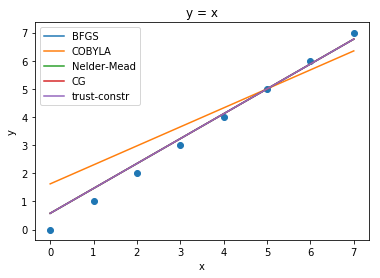

In [289]:
#first set up the data sets x and y

x = np.arange(0,8,1)
y = x #+ [random.uniform(-1,1) for p in range(8)]
N = len(x)
nqubits = math.ceil(np.log2(N))

ones = np.ones(N)/np.sqrt(N)    #need a normalised ones' state for including the parameter b

xnorm = np.linalg.norm(x)       #normalise data sets
ynorm = np.linalg.norm(y)
x = x/xnorm
y = y/ynorm

#x0 = [random.uniform(0,2) for p in range(2)]    #random initial guess for a and b
x0 = [0.5,0.5]

#now use different classical optimisers to see which one works best

out = minimize(calculate_cost_function, x0=x0, method="BFGS", options={'maxiter':200}, tol=1e-6)
out1 = minimize(calculate_cost_function, x0=x0, method="COBYLA", options={'maxiter':200}, tol=1e-6)
out2 = minimize(calculate_cost_function, x0=x0, method="Nelder-Mead", options={'maxiter':200}, tol=1e-6)
out3 = minimize(calculate_cost_function, x0=x0, method="CG", options={'maxiter':200}, tol=1e-6)
out4 = minimize(calculate_cost_function, x0=x0, method="trust-constr", options={'maxiter':200}, tol=1e-6)

out_a1 = out1['x'][0]
out_b1 = out1['x'][1]

print("COBYLA: ", out1)

out_a = out['x'][0]
out_b = out['x'][1]

print("BFGS: ", out)

out_a2 = out2['x'][0]
out_b2 = out2['x'][1]

print("Nelder-Mead: ", out2)

out_a3 = out3['x'][0]
out_b3 = out3['x'][1]

print("CG: ", out3)

out_a4 = out4['x'][0]
out_b4 = out4['x'][1]

print("trust-constr: ", out4)

plt.scatter(x*xnorm,y*ynorm)
xfit = np.linspace(min(x)*xnorm, max(x)*xnorm, 100)
#plt.plot(xfit, preout['x'][0]*xfit+preout['x'][1], label='Basinhopping')
plt.plot(xfit, out_a*xfit+out_b, label='BFGS')
plt.plot(xfit, out_a1*xfit+out_b1, label='COBYLA')
plt.plot(xfit, out_a2*xfit+out_b2, label='Nelder-Mead')
plt.plot(xfit, out_a3*xfit+out_b3, label='CG')
plt.plot(xfit, out_a4*xfit+out_b4, label='trust-constr')
plt.legend()
plt.title("y = x")
plt.xlabel("x")
plt.ylabel("y")
plt.show()